# Tutorial for WebbPSF: Computing Simulated Point Spread Functions for JWST

This tutorial will walk you through the basics of using the WebbPSF package to calculate PSFs for JWST. This focuses on the command-line/programming interface rather than the graphical interface. Let's begin.

First, we set up the notebook to display plots inline, and to plot images with the origin in the lower left.

In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['image.origin'] = 'lower'

## Getting Started

We assume you have already installed webbpsf from PyPI or some other source, and can successfully import it. 

In [2]:
import webbpsf

## First PSFs

Now let's get started with some calculations. WebbPSF provides a set of five objects corresponding to JWST's four instruments plus the FGS. To calculate a PSF, we first instantiate one of these: 

In [3]:
nc = webbpsf.NIRCam()

In the case of NIRCam, which has multiple detectors, the default is set to `NRCA1` for now.  The default filter is F200W. 

And then call its ``calcPSF`` function.  

The returned result is a fits HDUList object containing both the image data and its associated metadata in the header. 

In [4]:
psf = nc.calc_psf(nlambda=5, fov_arcsec=2)

We can display the PSF that we have just created:

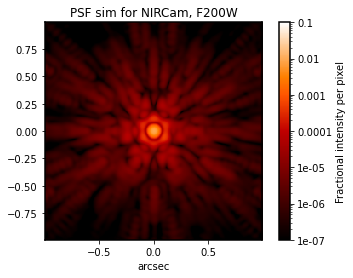

In [5]:
webbpsf.display_psf(psf)

The default behavior of WebbPSF is to compute *oversampled* PSFs (i.e. sampled more finely than the detector pixel scale) by a factor of 4. However, it also produces a version of the same PSF that has been downsampled onto the detector scale. This is saved as an image extension in the same result file. 

Since the PSFs are returned in regular FITS HDUList objects, we can examine, save, and generally manipulate them like any other HDUList. Let's look at the different extensions: 

In [6]:
psf.info()

Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU     108   (256, 256)   float64   
  1  DET_SAMP      1 ImageHDU       110   (64, 64)   float64   
  2  OVERDIST      1 ImageHDU       154   (256, 256)   float64   
  3  DET_DIST      1 ImageHDU       155   (64, 64)   float64   


In [7]:
for ext in [0, 1]:
    print(f"Extenstion {ext} has oversampling factor = ", psf[ext].header['OVERSAMP'], 
          f"\tPixelscale = {psf[ext].header['PIXELSCL']:.4f} arcsec/pix")

Extenstion 0 has oversampling factor =  4 	Pixelscale = 0.0078 arcsec/pix
Extenstion 1 has oversampling factor =  1 	Pixelscale = 0.0311 arcsec/pix


Extension 0, the primary image, is the oversampled computed PSF. Extension 1 has been binned down to the detector scale. 

The display functions in webbpsf allow you to specify an extension, either by index number or by extension name. Let's display the detector-sampled PSF from extension 1.

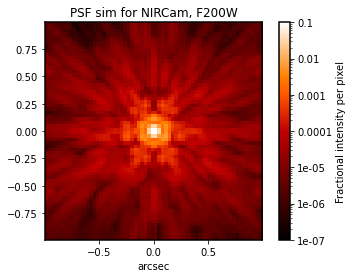

In [8]:
webbpsf.display_psf(psf,ext='DET_SAMP')

### Specifying instrument parameters

Instruments have properties corresponding to their configurable options, typically the bandpass filter and optional image plane and pupil plane masks.  

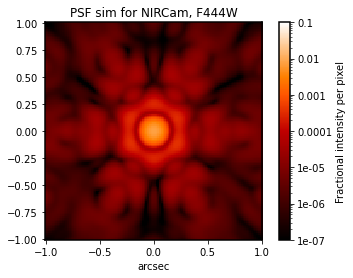

In [9]:
nc.filter='F444W'
psf444 = nc.calc_psf(fov_arcsec=2)
webbpsf.display_psf(psf444)

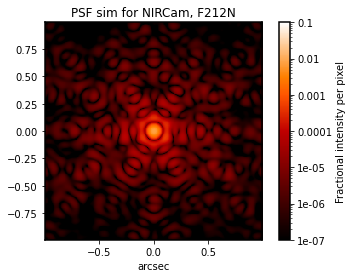

In [10]:
nc.filter='F212N'
psf212 = nc.calc_psf(fov_arcsec=2)
webbpsf.display_psf(psf212)

We can also specify different locations within an instrument. This will generally result in small but measurable differences. 

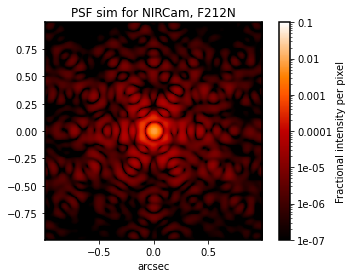

In [11]:
nc.detector='NRCB3'

nc.detector_position = (500, 1600)

psf212_nrcb3 = nc.calc_psf(fov_arcsec=2)
webbpsf.display_psf(psf212_nrcb3)

## A coronagraphic example

More complicated instrumental configurations are available by setting the instrument’s attributes. For instance, one can create an instance of MIRI and configure it for coronagraphic observations, as follows. This also shows off the ability to display the intermediate optical planes during a calculation:

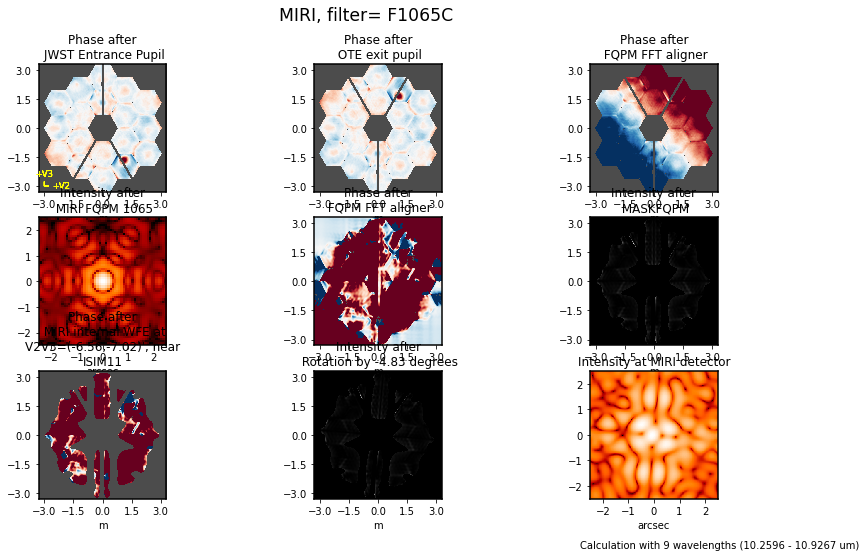

In [14]:
# optional: make the plot bigger so we can see everything more easily
matplotlib.pyplot.figure(figsize=(14, 8))

miri = webbpsf.MIRI()
miri.filter = 'F1065C'
miri.image_mask = 'FQPM1065'
miri.pupil_mask = 'MASKFQPM'
miri_coron = miri.calc_psf(display=True)

##  More Examples

Here are some other example calculations taken from elsewhere in the ``webbpsf`` documentation. 

Some of these differ cosmetically from the code there: this notebook contains some extra function calls to set an aesthetically pleasing size for each plot, and to save the outputs to PNGs. These lines are left out of the example docs HTML page just to streamline it a bit.

In [16]:
# Iterate over all instruments, calculating one example PSF for each
insts = ['NIRCam','NIRCam','NIRSpec','NIRISS', 'MIRI', 'FGS']
filts = ['F210M', 'F444W', 'F110W', 'F380M', 'F1000W', 'FGS']

psfs = {}
for i, (instname, filt) in enumerate(zip(insts, filts)):
    inst = webbpsf.instrument(instname)
    inst.filter = filt
    psf = inst.calc_psf(fov_arcsec=5.0)
    psfs[instname+filt] = psf
    print(inst)

<JWST: NIRCam>
<JWST: NIRCam>
<JWST: NIRSpec>
<JWST: NIRISS>
<JWST: MIRI>
<JWST: FGS>


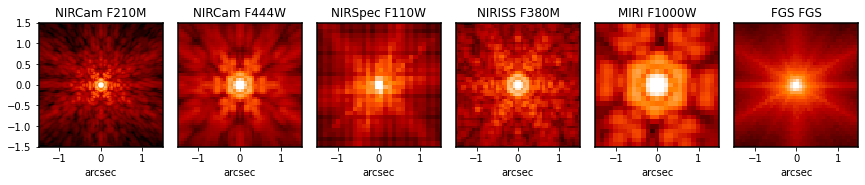

In [22]:
# Now make a nice plot of them
plt.figure(figsize=(16*0.75,3*0.75))
plt.subplots_adjust(wspace=0.05, bottom=0.05, top=0.9)
for i, (instname, filt) in enumerate(zip(insts, filts)):
    ax = plt.subplot(1,6,1+i)
    webbpsf.display_psf(psfs[instname+filt], colorbar=False, title=instname+" "+filt, vmax=0.03, imagecrop=3, ext=1)
    if i > 0:
        ax.yaxis.set_visible(False)
plt.tight_layout()
plt.savefig('fig_instrument_comparison.png', dpi=150)

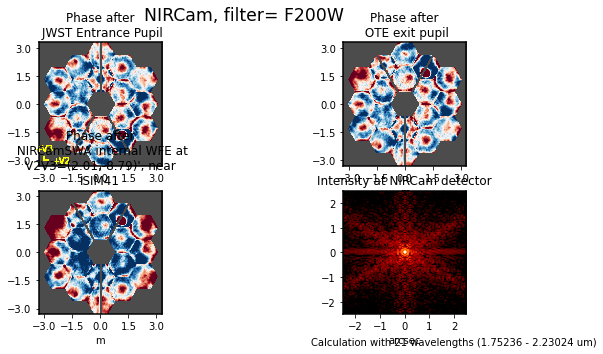

In [20]:
# Example plot of F200W calculation
plt.figure(figsize=(10,5))
nc = webbpsf.NIRCam()
nc.filter =  'F200W'
nc.calc_psf(display=True)    
plt.savefig('fig1_nircam_f200w.png', dpi=120)

## Displaying a PSF as an image and as an encircled energy plot


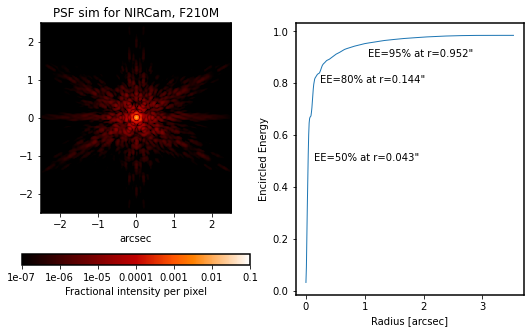

In [25]:
#create a NIRCam instance and calculate a PSF for F210M
nircam = webbpsf.NIRCam()
nircam.filter = 'F210M'
psf210 = nircam.calc_psf()

# display the PSF and plot the encircled energy
plt.figure(figsize=(9,5))
plt.subplot(1,2,1)
webbpsf.display_psf(psf210, colorbar_orientation='horizontal')
axis2 = plt.subplot(1,2,2)
webbpsf.display_ee(psf210, ax=axis2)

psf210.writeto('nircam_F210M.fits', overwrite=True)
plt.savefig('fig_example_plot_nircam_f210m.png')

## Logging and More Verbose Output

WebbPSF produces various log messages while it works, using Python's built-in logging mechanism. In order to see them, we need to set up a log handler that will display them on the screen. This is done using the ``setup_logging`` function. 

In [26]:
webbpsf.setup_logging()

WebbPSF log messages of level INFO and above will be shown.
WebbPSF log outputs will be directed to the screen.


We can also choose to save log outputs to a file, if that's desired.

In [27]:
webbpsf.setup_logging(filename='my_log.txt')

WebbPSF log messages of level INFO and above will be shown.
WebbPSF log outputs will be directed to the screen.
WebbPSF log outputs will also be saved to file my_log.txt


In [28]:
psf = nc.calc_psf(nlambda=5, fov_arcsec=2)

[  poppy] No source spectrum supplied, therefore defaulting to 5700 K blackbody
[  poppy] Computing wavelength weights using synthetic photometry for F200W...
[  poppy] PSF calc using fov_arcsec = 2.000000, oversample = 4, number of wavelengths = 5
[webbpsf] Creating optical system model:
[  poppy] Initialized OpticalSystem: JWST+NIRCam
[  poppy] JWST Entrance Pupil: Loaded amplitude transmission from /Users/mperrin/software/webbpsf-data/jwst_pupil_RevW_npix1024.fits.gz
[  poppy] JWST Entrance Pupil: Loaded OPD from /Users/mperrin/software/webbpsf-data/JWST_OTE_OPD_cycle1_example_2022-07-30.fits
[webbpsf] Loading field dependent model parameters from /Users/mperrin/software/webbpsf-data/NIRCam/OPD/field_dep_table_nircam.fits
[webbpsf] Calculating field-dependent OTE OPD at v2 = 2.009 arcmin, v3 = -8.795 arcmin
[  poppy] Added pupil plane: JWST Entrance Pupil
[  poppy] Added coordinate inversion plane: OTE exit pupil
[  poppy] Added pupil plane: NIRCamSWA internal WFE at V2V3=(2.01,-8.7

As you can see, the log output can be fairly verbose. This is often helpful in terms of understanding what's going on. 

If you no longer want this level of verbosity, you can turn off display of informational messages:

In [29]:
webbpsf.setup_logging('ERROR')

WebbPSF log messages of level ERROR and above will be shown.
WebbPSF log outputs will be directed to the screen.


## Jupyter Notebook Widget Interface

WebbPSF includes an interactive Jupyter notebook interface, which enables quick exploration of PSFs from changing some of the basic options such as filters and image or pupil masks. More complicated calculations need the Python API, but this can be useful for quick calculations.

In [4]:
webbpsf.show_notebook_interface('nircam')

HTML(value='<p style="padding: 1em 0;">\n    <span style="font-weight:bold; font-size:1.0em">\n    Notebook In…

Dropdown(description='Filter:', index=10, options=('F070W', 'F090W', 'F115W', 'F140M', 'F150W2', 'F150W', 'F16…

HTML(value='<p style="padding: 1em 0;">\n    <span style="font-style:italic; font-size:1.0em">\n    Monochroma…

HTML(value='<hr>')

Dropdown(description='Image Mask:', options=('None', 'MASKLWB', 'MASKSWB', 'MASK210R', 'MASK335R', 'MASK430R')…

Dropdown(description='Pupil Mask: ', options=('None', 'CIRCLYOT', 'WEDGELYOT', 'MASKRND', 'MASKSWB', 'MASKLWB'…

HTML(value='<hr>')

Dropdown(description='Source spectrum', index=43, options=('Power law F_nu ~ nu^(3)', 'Power law F_nu ~ nu^(2)…

HTML(value='<hr>')

HTML(value='<br/>')

HTML(value='<progress>')

HTML(value='\n    <a class="btn btn-info" href="files/psf.fits" target="_blank">\n        Download FITS image …